# Etude du problème d'optimisation

Question 1.1  
La définition de l'énergie auto-consommée (3) est interprétable de la manière suivante :  

$E^{PV}$ représente l'énergie produite par les panneaux photovoltaïques et ($w_{i}$ + $P_{i}\Delta$t) la somme des consommations non-pilotables de la maison et de l'énergie dépensée pour chauffer l'eau du ballon. Donc pour chaque i (chaque intervalle de temps) nous pouvons prendre le minimum des deux variables car nous avons trois cas :  
- Si $w_{i}$ + $P_{i}\Delta$ t > $E^{PV}_{i}$
Alors la totalité de l'énergie photovoltaïque a été consommée, on la comptabilise entièrement pour l'intervalle "i" concerné.

- Si $w_{i}$ + $P_{i}\Delta$ t < $E^{PV}_{i}$
Alors nous n'avons pas consommé la totalité de l'énergie photovoltaïque produite et le surplus de production a été revendu. Donc nous pouvons comptabiliser le terme minimal ($w_{i}$ + $P_{i}\Delta$ t) qui est égal à la consommation d'énergie photovoltaïque.

- Si $w_{i}$ + $P_{i}\Delta$ t = $E^{PV}_{i}$  
Alors peu importe le terme que nous ajoutons à la somme.  
  
La fonction min{$E^{PV}_{i}$, $w_{i}$ + $P_{i}\Delta$ t} revient à chercher :  
$E^{PV}_{i}$ < $w_{i}$ + $P_{i}\Delta$ t <=> $E^{PV}_{i}$ - $w_{i}$ < $P_{i}\Delta$ t  
En posant donc $Ê_{i}$ = $E^{PV}_{i}$ - $w_{i}$  
On remarque que les fonctions min{$E^{PV}_{i}$, $w_{i} + $P_{i}\Delta$ t} et min{$Ê_{i}$, $P_{i}\Delta$ t} sont équivalentes.  

La difficulté que comporte ces deux coûts dans la cadre d'un problème d'optimisation est que ce sont des fonctions **discontinues**.




Question 1.2

Supposons que $Ê_i < P_i \Delta t$ par symétrie (h est symétrique en $Ê_i$ et $P_i \Delta t$). 

On a donc $h(Ê_i, P_i \Delta t) = \frac{Ê_i + P_i \Delta te^{- \alpha (P_i\Delta t -Ê_i)}}{1+e^{- \alpha (P_i\Delta t-Ê_i)}}$.

Or $ \alpha (P_i \Delta t -Ê_i) >>1$ donc $e^{- \alpha (P_i\Delta t -Ê_i)} <<1$.

Par développement limité à l'ordre 0 exacte de la focntion $\frac{1}{1+x}$ et $1+x$, on a donc: $h(Ê_i, P_i \Delta t) = (Ê_i +0)*(1+0) = Ê_i$. Par symétrie, on a donc qu'à l'ordre 0 :
$$ h(Ê_i, P_i \Delta t) = min(Ê_i, P_i \Delta t)$$

L'avantage de la fonction h est qu'elle est $C^1$ et explicite, donc beaucoup plus facile à manipuler que la fonction minimum.

Question 1.3

Question 1.4

On veut maximiser (comme prouvé en 1.2) $\sum_{i=1}^{N} h(Ê_i, P_i \Delta t)$, donc minimiser $-\sum_{i=1}^{N} h(Ê_i, P_i \Delta t)$. La seule variable sur laquelle on a un contrôle est la puissance $P$, tous les autres facteurs (production, consommation etc) sont imposés. Donc il y a une unique variable de décision (n=1), qui est $P$. On définit donc $f(P)=-\sum_{i=1}^{N} h(Ê_i, P_i \Delta t)$, qui est la fonction à minimiser. La contrainte égalité que l'on a est la relation entre température et puissance, on peut donc définir pour i entre 0 et N-1: $c_{E,i}(P)= I_{i+1} - I_i e^{-k \Delta t}- \frac {1-e^{-k \Delta t}}{k} C(-Q_i+P_i)$ . 

Les contraintes inégalités qu'on a sont $c_{I,i}(P) = T_i-T_{sat}$, $c'_{I,i}(P) = P_i-P_{M}$, $c''_{I,i}(P) = -T_{i}$, $c'''_{I,i}(P) = -P_{i}$ liées aux contraintes de sécurité.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import casadi as cs

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      158
Number of nonzeros in inequality constraint Jacobian.:      212
Number of nonzeros in Lagrangian Hessian.............:       52

Total number of variables............................:      106
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       54
Total number of inequality constraints...............:      212
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      212

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.1365178e-02 7.56e+01 3.05e-04  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

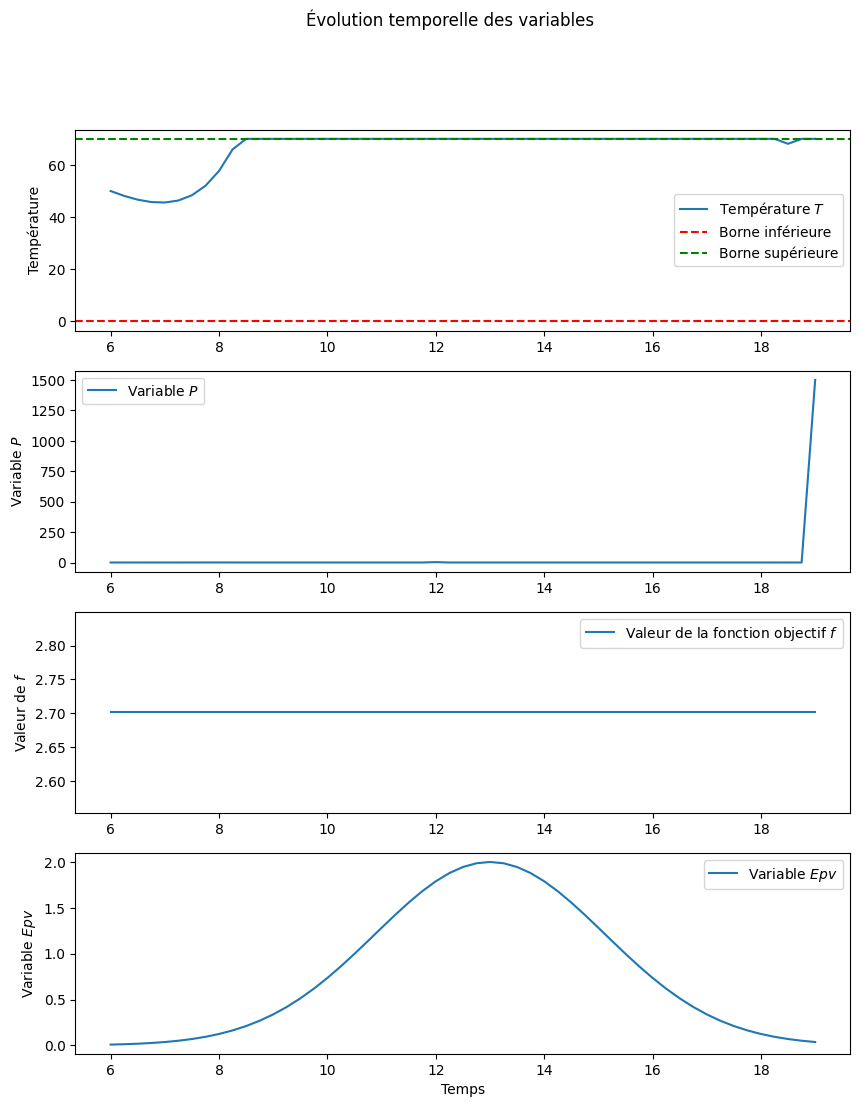

In [21]:


t0,tf=6,19
alpha=100
k=0.2
Tsat,Tin=70,50
C=100
Pm=3000
pas=0.25
N=int(1+(tf-t0)/pas)
Q=np.zeros((N,1))
Q[24]=3
Epv=np.array([2*np.exp(-((t-13)**2)/9) for t in np.arange(t0,tf+pas,pas)])
T=np.zeros((N,1))

def h(Ei, Pi_fois_pas):
    return((Ei*np.exp(-alpha*Ei)+Pi_fois_pas*np.exp(-alpha*Pi_fois_pas))/(np.exp(-alpha*Ei)+np.exp(-alpha*Pi_fois_pas)))

opti_cons = cs.Opti()
P = opti_cons.variable(N)
T = opti_cons.variable(N)
opti_cons.subject_to(T[0] == Tin)
f = 0
for i in range(N-1):
    f += -h(Epv[i],P[i]*pas)

opti_cons.minimize(f)
for i in range(N-1):
    opti_cons.subject_to(T[i+1]==T[i]*np.exp(-k*pas)+((1-np.exp(-k*pas))/k)*C*(-Q[i]+P[i]))

for i in range (N):
    opti_cons.subject_to(P[i]-Pm<=0)
    opti_cons.subject_to(-P[i]<=0)
    opti_cons.subject_to(T[i]-Tsat<=0)
    opti_cons.subject_to(-T[i]<=0)

opti_cons.subject_to(T[N-1] == Tsat)

opti_cons.set_initial(T,Tin)
opti_cons.solver('ipopt')
sol = opti_cons.solve()
T_values = sol.value(T)
f_value = sol.value(f)
P_values = sol.value(P)

# Créer un tableau de temps
temps = np.arange(t0, tf+pas, pas)

temps = np.arange(t0, tf+pas, pas)

# Créer une figure et des sous-graphiques
fig, axs = plt.subplots(4, 1, figsize=(10, 12))

# Tracer l'évolution temporelle de T
axs[0].plot(temps, T_values, label='Température $T$')
axs[0].axhline(0, color='r', linestyle='--', label='Borne inférieure')
axs[0].axhline(Tsat, color='g', linestyle='--', label='Borne supérieure')
axs[0].set_ylabel('Température')
axs[0].legend()

# Tracer l'évolution temporelle de P
axs[1].plot(temps, P_values, label='Variable $P$')
axs[1].set_ylabel('Variable $P$')
axs[1].legend()

# Tracer l'évolution temporelle de f
axs[2].plot(temps, -f_value * np.ones_like(temps), label='Evolution de l énergie autoconsommée')
axs[2].set_ylabel('Energie autoconsommée')
axs[2].legend()

# Tracer l'évolution temporelle de Epv
axs[3].plot(temps, Epv, label='Variable $Epv$')
axs[3].set_ylabel('Variable $Epv$')
axs[3].set_xlabel('Temps')
axs[3].legend()

# Titre global
plt.suptitle('Évolution temporelle des variables')

# Afficher les graphiques
plt.show()
